In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pandas.tseries.offsets import *
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from IPython.display import display

In [169]:
def prefecture_labeling(x):
     #文字列をラベリング
    label_encoder = LabelEncoder()
    labels = ["北海道","青森県","岩手県","宮城県","秋田県", 
"山形県", "福島県", "茨城県","栃木県","群馬県", 
"埼玉県","千葉県","東京都","神奈川県","新潟県", 
"富山県","石川県","福井県","山梨県","長野県", 
"岐阜県","静岡県","愛知県","三重県","滋賀県", 
"京都府","大阪府","兵庫県","奈良県","和歌山県", 
"鳥取県","島根県","岡山県","広島県","山口県", 
"徳島県","香川県","愛媛県","高知県","福岡県", 
"佐賀県","長崎県","熊本県","大分県","宮崎県", 
"鹿児島県","沖縄県",'その他（海外等）']
    label_encoder.fit(labels)
    le =label_encoder.transform(x)
    
    df = pd.DataFrame(le)
    column_name = ["prefecture"]
    df.columns = column_name
    
    return df
    

def gender_labeling(x):
    
    #文字列をラベリング
    label_encoder = LabelEncoder()
    labels = ["女性","男性"]
    label_encoder.fit(labels)
    le = label_encoder.transform(x)
    
    df = pd.DataFrame(le)
    column_name = ["gender"]
    df.columns = column_name
    
    return df

# 1.特徴量作成

In [3]:
log = pd.read_csv('log.tsv',delimiter="\t")
events = pd.read_csv('events.tsv', delimiter="\t")
users = pd.read_csv('users.tsv', delimiter="\t")
os.chdir('..')

In [4]:
print(log.shape)
log.head()

(1452089, 7)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN
3,1,125296,2017-06-06 14:01:27,1,NaN,NaN,NaN
4,1,125128,2017-06-06 14:03:57,1,NaN,NaN,NaN


In [5]:
print(events.shape)
events.head()

(158392, 11)


,event_id,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_start_at,prefecture,first_published_at,female_price,male_price,interest
0,1,20,99.0,25,44.0,2015-03-08 18:00:00,宮城県,NaN,1500.0,5000.0,NaN
1,2,30,99.0,30,49.0,2015-03-01 15:00:00,富山県,NaN,1000.0,6500.0,NaN
2,3,22,99.0,24,39.0,2015-03-07 19:00:00,富山県,NaN,1000.0,6000.0,NaN
3,4,20,99.0,25,44.0,2015-03-08 18:00:00,新潟県,NaN,1000.0,6000.0,NaN
4,5,20,99.0,20,39.0,2015-03-14 19:00:00,新潟県,NaN,1000.0,6000.0,NaN


In [6]:
print(users.shape)
users.head()

(69667, 5)


,user_id,age,gender,prefecture,created_on
0,1,34,女性,静岡県,2012-06-26
1,2,31,男性,鳥取県,2012-07-12
2,3,32,男性,東京都,2012-07-15
3,4,30,男性,東京都,2012-07-17
4,5,29,女性,埼玉県,2012-07-17


データ連結

In [7]:
merge1 = pd.merge(log,events, on ="event_id") 

In [8]:
merge2 = pd.merge(merge1,users, on ="user_id")

In [9]:
print(merge2.shape)
merge2.head(200)

(1450405, 21)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,event_start_at,prefecture_x,first_published_at,female_price,male_price,interest,age,gender,prefecture_y,created_on
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0,27,39.0,27,...,2015-03-22 14:00:00,東京都,NaN,4000.0,6500.0,NaN,34,女性,静岡県,2012-06-26
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
5,1,127600,2017-06-05 12:31:40,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
6,1,127600,2017-06-05 12:31:19,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
7,1,127600,2017-06-05 12:31:26,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
8,1,127600,2017-06-05 12:30:54,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
9,1,127600,2017-06-07 14:44:53,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26


In [10]:
merge2 = merge2.rename(columns = {"prefecture_x": "event_prefecture", "prefecture_y":"user_prefecture"})
merge2.head()

,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,event_start_at,event_prefecture,first_published_at,female_price,male_price,interest,age,gender,user_prefecture,created_on
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0,27,39.0,27,...,2015-03-22 14:00:00,東京都,NaN,4000.0,6500.0,NaN,34,女性,静岡県,2012-06-26
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26


# 特徴量を数値化

In [11]:
merge2.loc[:,"event_date"] = pd.to_datetime(merge2["event_start_at"])
merge2.loc[:,"event_year"] = merge2.loc[:,"event_date"].apply(lambda x:str(x.year))
merge2.loc[:,"event_month"] = merge2.loc[:,"event_date"].apply(lambda x:str(x.month))
merge2.loc[:,"event_day"] = merge2.loc[:,"event_date"].apply(lambda x:str(x.day))
merge2.loc[:,"event_weekday"] = merge2.loc[:,"event_date"].apply(lambda x:str(x.dayofweek))
merge2.loc[:,"event_hour"] = merge2.loc[:,"event_date"].apply(lambda x:str(x.hour))

merge2.head()

,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,age,gender,user_prefecture,created_on,event_date,event_year,event_month,event_day,event_weekday,event_hour
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0,27,39.0,27,...,34,女性,静岡県,2012-06-26,2015-03-22 14:00:00,2015,3,22,6,14
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,34,女性,静岡県,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,34,女性,静岡県,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,34,女性,静岡県,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,34,女性,静岡県,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10


In [12]:
merge2.loc[:,"user_date"] = pd.to_datetime(merge2["created_on"])
merge2.loc[:,"user_year"] = merge2.loc[:,"user_date"].apply(lambda x:str(x.year))
merge2.loc[:,"user_month"] = merge2.loc[:,"user_date"].apply(lambda x:str(x.month))
merge2.head()

,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,created_on,event_date,event_year,event_month,event_day,event_weekday,event_hour,user_date,user_year,user_month
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0,27,39.0,27,...,2012-06-26,2015-03-22 14:00:00,2015,3,22,6,14,2012-06-26,2012,6
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6


### 時間を数値化

In [13]:
merge2["time_stamp"] = pd.to_datetime(merge2["time_stamp"])

In [14]:
merge2["first_published_at"] = pd.to_datetime(merge2["first_published_at"])

In [17]:
print(merge2.shape)
merge2.head()

(1450405, 21)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,event_start_at,prefecture_x,first_published_at,female_price,male_price,interest,age,gender,prefecture_y,created_on
0,1,6261,2015-03-19 09:15:50,3,1.0,クレカ,4000.0,27,39.0,27,...,2015-03-22 14:00:00,東京都,NaT,4000.0,6500.0,NaN,34,女性,静岡県,2012-06-26
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2017-06-11 10:00:00,埼玉県,2017-05-01 14:57:33,2000.0,6000.0,NaN,34,女性,静岡県,2012-06-26


### データを数値にする

下の処理に約3分

In [15]:
merge2 = merge2.replace("クレカ", 0)
merge2 = merge2.replace("コンビニ", 1)
merge2 = merge2.replace("eマネー", 2)
print(merge2.shape)
merge2.head()

(1450405, 30)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,created_on,event_date,event_year,event_month,event_day,event_weekday,event_hour,user_date,user_year,user_month
0,1,6261,2015-03-19 09:15:50,3,1.0,0,4000.0,27,39.0,27,...,2012-06-26,2015-03-22 14:00:00,2015,3,22,6,14,2012-06-26,2012,6
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6


下の処理に約2分

In [16]:
merge2 = merge2.replace("女性", 1)
merge2 = merge2.replace("男性", 2)
print(merge2.shape)
merge2.head()

(1450405, 30)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,created_on,event_date,event_year,event_month,event_day,event_weekday,event_hour,user_date,user_year,user_month
0,1,6261,2015-03-19 09:15:50,3,1.0,0,4000.0,27,39.0,27,...,2012-06-26,2015-03-22 14:00:00,2015,3,22,6,14,2012-06-26,2012,6
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6


In [38]:
merge2 = merge2.replace("北海道", 1)
merge2 = merge2.replace("青森県", 2)
merge2 = merge2.replace("岩手県", 3)
merge2 = merge2.replace("宮城県", 4)
merge2 = merge2.replace("秋田県", 5)
merge2 = merge2.replace("山形県", 6)
merge2 = merge2.replace("福島県", 7)
merge2 = merge2.replace("茨城県", 8)
merge2 = merge2.replace("栃木県", 9)
merge2 = merge2.replace("群馬県", 10)
merge2 = merge2.replace("埼玉県", 11)
merge2 = merge2.replace("千葉県", 12)
merge2 = merge2.replace("東京都", 13)
merge2 = merge2.replace("神奈川県", 14)
merge2 = merge2.replace("新潟県", 15)
merge2 = merge2.replace("富山県", 16)
merge2 = merge2.replace("石川県", 17)
merge2 = merge2.replace("福井県", 18)
merge2 = merge2.replace("山梨県", 19)
merge2 = merge2.replace("長野県", 20)
merge2 = merge2.replace("岐阜県", 21)
merge2 = merge2.replace("静岡県", 22)
merge2 = merge2.replace("愛知県", 23)
merge2 = merge2.replace("三重県", 24)
merge2 = merge2.replace("滋賀県", 25)
merge2 = merge2.replace("京都府", 26)
merge2 = merge2.replace("大阪府", 27)
merge2 = merge2.replace("兵庫県", 28)
merge2 = merge2.replace("奈良県", 29)
merge2 = merge2.replace("和歌山県", 30)
merge2 = merge2.replace("鳥取県", 31)
merge2 = merge2.replace("島根県", 32)
merge2 = merge2.replace("岡山県", 33)
merge2 = merge2.replace("広島県", 34)
merge2 = merge2.replace("山口県", 35)
merge2 = merge2.replace("徳島県", 36)
merge2 = merge2.replace("香川県", 37)
merge2 = merge2.replace("愛媛県", 38)
merge2 = merge2.replace("高知県", 39)
merge2 = merge2.replace("福岡県", 40)
merge2 = merge2.replace("佐賀県", 41)
merge2 = merge2.replace("長崎県", 42)
merge2 = merge2.replace("熊本県", 43)
merge2 = merge2.replace("大分県", 44)
merge2 = merge2.replace("宮崎県", 45)
merge2 = merge2.replace("鹿児島県", 46)
merge2 = merge2.replace("沖縄県", 47)
merge2 = merge2.replace("その他（海外等）", 48)

KeyboardInterrupt: 

In [49]:
print(merge2.shape)
merge2.head()

(1450405, 30)


,user_id,event_id,time_stamp,action_type,num_of_people,payment_method,total_price,female_age_lower,female_age_upper,male_age_lower,...,created_on,event_date,event_year,event_month,event_day,event_weekday,event_hour,user_date,user_year,user_month
0,1,6261,2015-03-19 09:15:50,3,1.0,0,4000.0,27,39.0,27,...,2012-06-26,2015-03-22 14:00:00,2015,3,22,6,14,2012-06-26,2012,6
1,1,127600,2017-06-05 12:33:17,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
2,1,127600,2017-06-05 12:37:09,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
3,1,127600,2017-06-05 12:32:04,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6
4,1,127600,2017-06-06 09:37:45,1,NaN,NaN,NaN,24,36.0,26,...,2012-06-26,2017-06-11 10:00:00,2017,6,11,6,10,2012-06-26,2012,6


column確認

In [50]:
merge2.columns

Index(['user_id', 'event_id', 'time_stamp', 'action_type', 'num_of_people',
       'payment_method', 'total_price', 'female_age_lower', 'female_age_upper',
       'male_age_lower', 'male_age_upper', 'event_start_at',
       'event_prefecture', 'first_published_at', 'female_price', 'male_price',
       'interest', 'age', 'gender', 'user_prefecture', 'created_on',
       'event_date', 'event_year', 'event_month', 'event_day', 'event_weekday',
       'event_hour', 'user_date', 'user_year', 'user_month'],
      dtype='object')

Nanを探す

In [100]:
data[data.isnull().any(1)]

,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_prefecture,female_price,male_price,age,gender,user_prefecture,event_year,event_month,event_day,event_weekday,event_hour,user_year,user_month,action_type
524,20,49.0,20,49.0,13,NaN,3000.0,34,1,22,2017,6,14,2,10,2012,6,1
679,22,NaN,24,39.0,20,2000.0,6000.0,34,1,22,2017,5,14,6,18,2012,6,1
893,20,49.0,20,49.0,13,NaN,3000.0,34,1,22,2017,7,20,3,10,2012,6,1
964,20,NaN,25,44.0,17,1000.0,6000.0,34,1,22,2017,8,5,5,19,2012,6,1
1097,25,45.0,25,45.0,11,NaN,NaN,34,1,22,2016,9,22,3,10,2012,6,1
1427,25,40.0,28,42.0,13,NaN,NaN,40,1,11,2017,9,17,6,8,2012,10,1
1463,25,39.0,25,39.0,13,NaN,NaN,40,1,11,2017,6,25,6,9,2012,10,1
1466,30,45.0,30,45.0,13,NaN,NaN,40,1,11,2017,6,24,5,9,2012,10,1
2350,20,34.0,20,34.0,13,NaN,NaN,24,2,11,2017,3,18,5,6,2015,7,1
2595,20,49.0,20,49.0,13,NaN,3000.0,24,2,11,2017,6,2,4,10,2015,7,1


特徴量決定

In [117]:
features = ["female_age_lower","female_age_upper","male_age_lower","male_age_upper","event_prefecture","female_price","male_price",
            "age", "gender", "user_prefecture","event_year", "event_month",
           "event_day","event_weekday", "event_hour", "user_year", "user_month"]
target = ["action_type"]

categorical = ["event_prefecture", "gender", "user_prefecture", 'event_year',"event_month","event_day","event_weekday", "event_hour", "user_year", "user_month"]

In [118]:
merge2[features].head(100)

,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_prefecture,female_price,male_price,age,gender,user_prefecture,event_year,event_month,event_day,event_weekday,event_hour,user_year,user_month
0,27,39.0,27,39.0,13,4000.0,6500.0,34,1,22,2015,3,22,6,14,2012,6
1,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
2,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
3,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
4,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
5,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
6,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
7,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
8,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
9,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6


In [119]:
data =merge2[features + target]
#naの行消す
#data = data.dropna()
#data = data.reset_index(drop=True)
print(data.shape)
data.head()

(1450405, 18)


,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_prefecture,female_price,male_price,age,gender,user_prefecture,event_year,event_month,event_day,event_weekday,event_hour,user_year,user_month,action_type
0,27,39.0,27,39.0,13,4000.0,6500.0,34,1,22,2015,3,22,6,14,2012,6,3
1,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6,1
2,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6,1
3,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6,1
4,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6,1


In [120]:
X = data[features]
print(X.shape)
X.head(200)

(1450405, 17)


,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_prefecture,female_price,male_price,age,gender,user_prefecture,event_year,event_month,event_day,event_weekday,event_hour,user_year,user_month
0,27,39.0,27,39.0,13,4000.0,6500.0,34,1,22,2015,3,22,6,14,2012,6
1,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
2,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
3,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
4,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
5,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
6,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
7,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
8,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6
9,24,36.0,26,38.0,11,2000.0,6000.0,34,1,22,2017,6,11,6,10,2012,6


event_year, event_month, event_day, event_weekday, event_hour, user_year, user_monthをstr型からint型にする

In [123]:
type(X["event_year"][0])

str

In [126]:
X["event_year"] = X["event_year"].astype(np.int64)
X["event_month"] = X["event_month"].astype(np.int64)
X["event_day"] = X["event_day"].astype(np.int64)
X["event_weekday"] = X["event_weekday"].astype(np.int64)
X["event_hour"] = X["event_hour"].astype(np.int64)
X["user_year"] = X["user_year"].astype(np.int64)
X["user_month"] = X["user_month"].astype(np.int64)

C:\Users\Mustang8\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



y作成

In [134]:
y = data.loc[:,target]
print(y.shape)
y.head()

(1450405, 1)


,action_type
0,3
1,1
2,1
3,1
4,1


### 学習

train valid分割

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_valid,y_train, y_valid = train_test_split(
    X,y, test_size=0.3, random_state=0)

モデル構築

In [137]:
reg = xgb.XGBRegressor()

In [138]:
reg_cv = GridSearchCV(reg,  {'learning_rate':[0.1 , 0.5], 'max_depth':[5, 10], 'subsample':[0.5,1.0],'n_estimators':[50,100],
                             'colsample_bytree':[0.5,0.75,1.0]}, verbose=1)
reg_cv.fit(X_train, y_train)
print( reg_cv.best_params_, reg_cv.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 244.6min finished


{'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0} 0.424266770929569


In [139]:
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

# 評価（train,validデータに対してaction_typeとの比較）

2時間くらい

In [140]:
pred_train = reg.predict(X_train)
pred_valid = reg.predict(X_valid)

評価

In [141]:
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, pred_train), mean_squared_error(y_valid, pred_valid)) )
# R^2
from sklearn.metrics import r2_score
print('R^2 train : %.3f, test : %.3f' % (r2_score(y_train, pred_train), r2_score(y_valid, pred_valid)) )

MSE train : 0.271, test : 0.329
R^2 train : 0.541, test : 0.444


typeとcolumn変更

In [142]:
Pred_train = pd.DataFrame(pred_train)
Pred_train = Pred_train.rename( columns = { 0 : "pred_action_type" } )
print(Pred_train.shape)
Pred_train

(1015283, 1)


,pred_action_type
0,1.834671
1,2.194486
2,1.416649
3,1.300308
4,1.069770
5,1.913362
6,1.279217
7,1.231254
8,1.047270
9,1.670067


In [143]:
Pred_valid = pd.DataFrame(pred_valid)
Pred_valid = Pred_valid.rename( columns = { 0 : "pred_action_type" } )
print(Pred_valid.shape)
Pred_valid

(435122, 1)


,pred_action_type
0,2.210290
1,2.693959
2,2.454557
3,1.056308
4,2.322633
5,1.157452
6,1.349962
7,1.300626
8,3.135765
9,1.739686


index調整

In [144]:
Pred_train.index = y_train.index

In [145]:
Pred_valid.index = y_valid.index

In [146]:
TRAIN =pd.concat([y_train["action_type"],Pred_train["pred_action_type"]],axis=1)

In [147]:
VALID =pd.concat([y_valid["action_type"],Pred_valid["pred_action_type"]],axis=1)

In [148]:
Result =pd.concat([TRAIN,VALID],axis=0).sort_index(ascending=True)

# action_typeとpred_action_typeを比較

In [149]:
Result

,action_type,pred_action_type
0,3,2.736195
1,1,1.030563
2,1,1.030563
3,1,1.030563
4,1,1.030563
5,1,1.030563
6,1,1.030563
7,1,1.030563
8,1,1.030563
9,1,1.030563


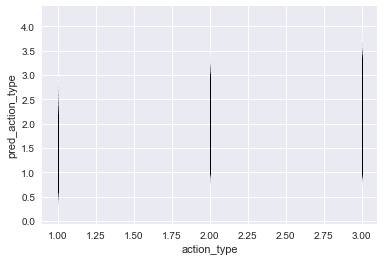

In [150]:
plt.scatter(Result["action_type"],Result["pred_action_type"],  c = 'black', marker = 's', s = 1, alpha = 0.01,)
plt.xlabel('action_type')
plt.ylabel('pred_action_type')

Ｆ値

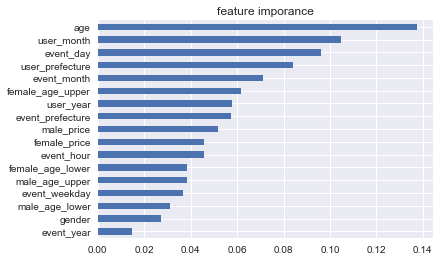

In [151]:
importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("feature imporance")
plt.show()

年齢と女性の上限の年齢の重要度高い…つらい

# Predict

In [158]:
os.chdir('レコメンド＿event')

In [159]:
test = pd.read_csv('test.tsv', delimiter="\t")
os.chdir('..')

In [161]:
test

,user_id
0,1
1,6
2,23
3,43
4,46
5,48
6,76
7,79
8,104
9,139


In [160]:
print(users.shape)
users.head()

(69667, 5)


,user_id,age,gender,prefecture,created_on
0,1,34,女性,静岡県,2012-06-26
1,2,31,男性,鳥取県,2012-07-12
2,3,32,男性,東京都,2012-07-15
3,4,30,男性,東京都,2012-07-17
4,5,29,女性,埼玉県,2012-07-17


In [162]:
user_list = test["user_id"]
event_list = events["event_id"]

ユーザー１に対して

In [164]:
events.loc[:,"user_id"] = 1

user_data = pd.merge(events, users, on = "user_id")
user_data = user_data.rename(columns = {"prefecture_x": "event_prefecture", "prefecture_y":"user_prefecture"})

user_data.loc[:,"event_date"] = pd.to_datetime(user_data["event_start_at"])
user_data.loc[:,"event_year"] = user_data.loc[:,"event_date"].apply(lambda x:str(x.year))
user_data.loc[:,"event_month"] = user_data.loc[:,"event_date"].apply(lambda x:str(x.month))
user_data.loc[:,"event_day"] = user_data.loc[:,"event_date"].apply(lambda x:str(x.day))
user_data.loc[:,"event_weekday"] = user_data.loc[:,"event_date"].apply(lambda x:str(x.dayofweek))
user_data.loc[:,"event_hour"] = user_data.loc[:,"event_date"].apply(lambda x:str(x.hour))

user_data.loc[:,"user_date"] = pd.to_datetime(user_data["created_on"])
user_data.loc[:,"user_year"] = user_data.loc[:,"user_date"].apply(lambda x:str(x.year))
user_data.loc[:,"user_month"] = user_data.loc[:,"user_date"].apply(lambda x:str(x.month))

print(user_data.shape)
user_data.head()

(158392, 25)


,event_id,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_start_at,event_prefecture,first_published_at,female_price,male_price,...,created_on,event_date,event_year,event_month,event_day,event_weekday,event_hour,user_date,user_year,user_month
0,1,20,99.0,25,44.0,2015-03-08 18:00:00,宮城県,NaN,1500.0,5000.0,...,2012-06-26,2015-03-08 18:00:00,2015,3,8,6,18,2012-06-26,2012,6
1,2,30,99.0,30,49.0,2015-03-01 15:00:00,富山県,NaN,1000.0,6500.0,...,2012-06-26,2015-03-01 15:00:00,2015,3,1,6,15,2012-06-26,2012,6
2,3,22,99.0,24,39.0,2015-03-07 19:00:00,富山県,NaN,1000.0,6000.0,...,2012-06-26,2015-03-07 19:00:00,2015,3,7,5,19,2012-06-26,2012,6
3,4,20,99.0,25,44.0,2015-03-08 18:00:00,新潟県,NaN,1000.0,6000.0,...,2012-06-26,2015-03-08 18:00:00,2015,3,8,6,18,2012-06-26,2012,6
4,5,20,99.0,20,39.0,2015-03-14 19:00:00,新潟県,NaN,1000.0,6000.0,...,2012-06-26,2015-03-14 19:00:00,2015,3,14,5,19,2012-06-26,2012,6


In [165]:
X = user_data[features]
print(X.shape)
X.head()

(158392, 17)


,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_prefecture,female_price,male_price,age,gender,user_prefecture,event_year,event_month,event_day,event_weekday,event_hour,user_year,user_month
0,20,99.0,25,44.0,宮城県,1500.0,5000.0,34,女性,静岡県,2015,3,8,6,18,2012,6
1,30,99.0,30,49.0,富山県,1000.0,6500.0,34,女性,静岡県,2015,3,1,6,15,2012,6
2,22,99.0,24,39.0,富山県,1000.0,6000.0,34,女性,静岡県,2015,3,7,5,19,2012,6
3,20,99.0,25,44.0,新潟県,1000.0,6000.0,34,女性,静岡県,2015,3,8,6,18,2012,6
4,20,99.0,20,39.0,新潟県,1000.0,6000.0,34,女性,静岡県,2015,3,14,5,19,2012,6


In [170]:
e_pre = prefecture_labeling(X["event_prefecture"])
e_pre.columns = "event_" + e_pre.columns.values
u_pre = prefecture_labeling(X["user_prefecture"])
u_pre.columns = "user_" + u_pre.columns.values
gen = gender_labeling(X["gender"])

temp = X[list(set(features) - set(["user_prefecture", "event_prefecture", "gender"]))]
print(temp.shape)
temp = pd.concat((temp,gen), axis = 1)
temp = pd.concat((temp,e_pre), axis = 1)
temp = pd.concat((temp,u_pre), axis = 1)

temp.loc[:,categorical] = temp.loc[:,categorical].astype(np.int64)

X = temp
print(X.shape)
X.head()

(158392, 14)
(158392, 17)


,event_weekday,event_year,male_age_lower,event_hour,female_price,event_day,user_month,female_age_upper,female_age_lower,age,event_month,male_age_upper,male_price,user_year,gender,event_prefecture,user_prefecture
0,6,2015,25,18,1500.0,8,6,99.0,20,34,3,44.0,5000.0,2012,0,12,43
1,6,2015,30,15,1000.0,1,6,99.0,30,34,3,49.0,6500.0,2012,0,14,43
2,5,2015,24,19,1000.0,7,6,99.0,22,34,3,39.0,6000.0,2012,0,14,43
3,6,2015,25,18,1000.0,8,6,99.0,20,34,3,44.0,6000.0,2012,0,26,43
4,5,2015,20,19,1000.0,14,6,99.0,20,34,3,39.0,6000.0,2012,0,26,43


In [177]:
features

['female_age_lower',
 'female_age_upper',
 'male_age_lower',
 'male_age_upper',
 'event_prefecture',
 'female_price',
 'male_price',
 'age',
 'gender',
 'user_prefecture',
 'event_year',
 'event_month',
 'event_day',
 'event_weekday',
 'event_hour',
 'user_year',
 'user_month']

In [175]:
X.columns

Index(['event_weekday', 'event_year', 'male_age_lower', 'event_hour',
       'female_price', 'event_day', 'user_month', 'female_age_upper',
       'female_age_lower', 'age', 'event_month', 'male_age_upper',
       'male_price', 'user_year', 'gender', 'event_prefecture',
       'user_prefecture'],
      dtype='object')

In [178]:
X1 = X[features]

In [179]:
y_pred = reg.predict(X1)

In [180]:
y_pred

array([2.5814779, 1.8971577, 2.1750417, ..., 2.8968413, 2.1740985,
       1.6717736], dtype=float32)

In [181]:
result = pd.DataFrame({"event_id":event_list})
result.loc[:,"predict"] = y_pred

In [182]:
print(result.shape)
result.head()

(158392, 2)


,event_id,predict
0,1,2.581478
1,2,1.897158
2,3,2.175042
3,4,2.705629
4,5,2.243245


In [183]:
result = result.sort_values(by=["predict"], ascending=False)
result = result.reset_index(drop = True)
result.loc[:,"rank"] = result.index.values + 1
result.head()

,event_id,predict,rank
0,21158,5.025292,1
1,18691,4.952422,2
2,12576,4.932302,3
3,13358,4.802389,4
4,19757,4.751874,5


In [184]:
result.shape

(158392, 3)

In [185]:
result.head(100)

,event_id,predict,rank
0,21158,5.025292,1
1,18691,4.952422,2
2,12576,4.932302,3
3,13358,4.802389,4
4,19757,4.751874,5
5,18839,4.748932,6
6,14706,4.714566,7
7,13423,4.711646,8
8,17864,4.694074,9
9,17993,4.656909,10


# 全体

In [186]:
#2017-9-24~2017-9-30のログを予想すればよいので，eventを絞る
events.loc[:,"event_date"] = pd.to_datetime(events["event_start_at"])

events = events.loc[events["event_date"] > pd.to_datetime("24/9/2017"),:]
events = events.reset_index(drop = True)
print(events.shape)
events.head()

event_list = events["event_id"]

(2422, 13)


In [199]:
X1.tail()

,female_age_lower,female_age_upper,male_age_lower,male_age_upper,event_prefecture,female_price,male_price,age,gender,user_prefecture,event_year,event_month,event_day,event_weekday,event_hour,user_year,user_month
158387,23,37.0,25,39.0,12,2500.0,6500.0,34,0,43,2017,9,30,5,19,2012,6
158388,30,45.0,35,49.0,33,3000.0,7000.0,34,0,43,2017,9,23,5,19,2012,6
158389,30,45.0,35,49.0,33,3000.0,7000.0,34,0,43,2017,9,30,5,19,2012,6
158390,30,45.0,35,49.0,27,3500.0,6000.0,34,0,43,2017,9,24,6,17,2012,6
158391,20,32.0,25,40.0,35,2500.0,6000.0,34,0,43,2017,9,24,6,19,2012,6


In [194]:
predict_by_user = []#{(user_id,event_id):estimated_r}を格納
recommends = []
k= 20
i = 0

for user in user_list:
    predict_by_user = []
    i = i +1
    print("user_id:"+str(user))
    print("進捗:"+str(i*100/len(user_list))+"%") 
    for event in event_list:
        y_predict = reg.predict(X1)
        
        y_predict = {"id":(user,event)}
        predict_by_user.append(y_predict)
    
    recommends_by_user = sorted(y_predict_by_user, key=lambda x:x["estimated_value"], reverse=True)[:k]
    recommends.append(recommends_by_user)

user_id:1
進捗:0.03465003465003465%


ValueError: feature_names mismatch: ['female_age_lower', 'female_age_upper', 'male_age_lower', 'male_age_upper', 'event_prefecture', 'female_price', 'male_price', 'age', 'gender', 'user_prefecture', 'event_year', 'event_month', 'event_day', 'event_weekday', 'event_hour', 'user_year', 'user_month'] ['event_weekday', 'event_year', 'male_age_lower', 'event_hour', 'female_price', 'event_day', 'user_month', 'female_age_upper', 'female_age_lower', 'age', 'event_month', 'male_age_upper', 'male_price', 'user_year', 'gender', 'event_prefecture', 'user_prefecture']

In [ ]:
df = pd.DataFrame(recommends)
df = pd.DataFrame(df.values.flatten())
df = df.rename(columns={0: "result"})
df.head()

In [ ]:
df.loc[:,"user_id"] = df["result"].apply(lambda x:x["id"][0])
df.loc[:,"event_id"] = df["result"].apply(lambda x:x["id"][1])
df.loc[:,"estimated_value"] = df["result"].apply(lambda x:x["estimated_value"])
#df.loc[:,"rank"] = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] * len(user_list) 
df.loc[:,"rank"] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] * len(user_list)

In [ ]:
submition = df[["user_id","event_id","rank"]]
print(submition.shape)
submition.head()

In [ ]:
submition.to_csv("sub.tsv",header=None,index=None,sep = "\t")